In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 11 2021

@author: Zsuzsanna Koczor-Benda, UCL
"""

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector
from plotting_functions import get_intensities,broadened_spec_single,get_intens_range,get_target,build_molecules,plot_spectra,write_html

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import pandas as pd
import qgrid
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import HBox, Layout,VBox

# Load data for all molecules

In [3]:
# Quantities to load:

# wn, R_spec, IR_spec:               wavenumbers, Raman and IR broadened spectra
# freqs:                             normal mode frequencies 
# prod_ints, R_ints, IR_ints:        conversion, Raman, and IR intensties for each normal mode
# smiles, fname:                     smiles codes and database codes of molecules
# P, A, R:                           THz conversion, IR absorption, and Raman target properties for xmin-xmax range


xmin=0      # minimum wavenumber to load (in cm-1)
xmax=4000   # maximum wavenumber to load (in cm-1)

# get intensities and target properties for all molecules
freqs0,prod_ints,R_ints,IR_ints,smiles,fname,P,A,R,R_fre,IR_fre,P_fre=get_intensities(xmin,xmax,sclf=1)

2847 molecules read, maximum number of normal modes: 186
Target properties calculated


# Distribution of chosen target property values in the database

In [4]:
# Distribution of P,A, or R for range 30-1000 cm-1 is centered at 0 with std=1 for random set of molecules
# Current dataset contains 1.3k random molecules + 1.5k molecules selected based on ML predictions

# def line_select_callback(eclick, erelease):
#     'eclick and erelease are the press and release events'
#     x1, y1 = eclick.xdata, eclick.ydata
#     x2, y2 = erelease.xdata, erelease.ydata
    
def plot_histogram(target_type,trange,sclf):
    tmin=trange[0]
    tmax=trange[1]

    if target_type=="P":
        intens=prod_ints
    elif target_type=="R":
        intens=R_ints
    elif target_type=="A":
        intens=IR_ints
        
    freqs=freqs0*sclf

    intens_range=get_intens_range(freqs,intens,tmin,tmax)      # get intensities in freq range
    target=get_target(intens_range,target_type)                # get chosen target for freq range
    
    plt.close('Histogram')
    fig, ax = plt.subplots(num='Histogram')
    fig.set_size_inches(6, 4)
    
#     print("Click and drag to draw a selection area - x only\n")
#     rect_select = RectangleSelector(ax, line_select_callback,
#                                        drawtype='box', useblit=True,
#                                        button=[1, 3],  # don't use middle button
#                                        minspanx=5, minspany=5,
#                                        spancoords='pixels',
#                                        interactive=True)

    if np.isinf(target).any():    # if there are molecules with 0 intensity in range, target will be -infinity
        print("Number of molecules with no modes in range: ",len(target[target < -1E2]))
    plt.hist(target[target > -1E2],20,width=0.25)  # skip molecules with too small target value 
    plt.xlabel("{} for range {}-{} cm-1".format(target_type,tmin,tmax))
    plt.ylabel("counts")
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.show()
    return target,intens_range,freqs


In [5]:
%matplotlib widget


layout = widgets.Layout(width='500px', height='40px',description_width='400px') #set width and height


interactive_plot = interactive(plot_histogram, {'manual': True}, 
         target_type=widgets.RadioButtons(options=[['Conversion','P'], ['Absorption','A'],['Raman','R']],
                                          description='Target property:',
                                          style={'description_width': 'initial'},
                                          disabled=False),
         trange=widgets.FloatRangeSlider(
                    min=0,
                    max=3800,
                    value=[30,1000],
                    step=1,
                    continuous_update=False,
                    orientation='horizontal',
                    description='Frequency range (cm-1):',            
                    layout=layout,
                    style={'description_width': 'initial'}
                           ),
         sclf=widgets.FloatSlider(value=0.98,min=0.9,max=1.1,step=0.01,description='Frequency scaling factor',
                                  continuous_update=False,
                                  disabled=False,style={'description_width': 'initial'}),
         );

output = interactive_plot.children[-1]
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap')) #'column'))
#output.layout.height = '650px'
#interactive_plot
display(VBox([controls,output]))


# Visualize chosen molecules

In [6]:
# Change variables here
# saving slows down code
res=0.5     # resolution of the widened spectra (in cm-1), default=0.5
gammaIR=5   # IR peak FWHM (in cm-1), default=5
gammaR=5    # Raman peak FWHM (in cm-1), default=5
nummols=3        # number of molecules to plot
best=True         # get best molecules (True) or worst molecules (False)
nummodes=3       # number of best normal modes per molecule to print out

In [7]:
if 'target_type' in interactive_plot.kwargs:
    target_type=interactive_plot.kwargs['target_type']
    tmin=interactive_plot.kwargs['trange'][0]
    tmax=interactive_plot.kwargs['trange'][1]
    sclf=interactive_plot.kwargs['sclf']
    target=interactive_plot.result[0]
    intens_range=interactive_plot.result[1]
    freqs=interactive_plot.result[2]

    if best:
        bestmols=list(reversed(np.argsort(target)[-nummols:])) # best molecules
    else:
        bestmols=np.argsort(target)[:nummols]                  # worst molecules
    bestsmiles=[smiles[i] for i in bestmols]                   # corresponding smiles codes
    mols,errs =  build_molecules(bestsmiles)                   # build RDKit molecules
    print("Total number of molecules: {}, chosen: {}, number of errors: {} at mols {}".format(len(smiles),
                                                                                        len(mols),len(errs),errs))

Total number of molecules: 2847, chosen: 3, number of errors: 0 at mols []
513.0 2310.0



###################################################################
Molecule 000-752-142
###################################################################


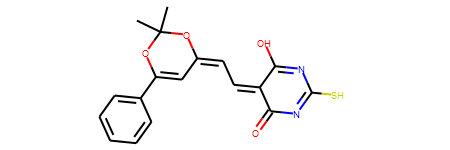

Properties for range 0-4000 cm-1 
P=11.994 A=7.884 R=5.494
P for range 513.0-2310.0 cm-1 = 11.993


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


Best normal modes in range 513.0-2310.0 cm-1, type P
--------------------------------------------------
Mode 96 at 1578.1 cm-1 / 47.31 THz
Conversion Intensity 	1.48e-24 km cm^2/(sr mol)
Raman Stokes Intensity 	7.58e-29 cm^2/sr
IR Intensity 		3.50e+03 km/mol
--------------------------------------------------
Mode 92 at 1461.5 cm-1 / 43.82 THz
Conversion Intensity 	2.95e-26 km cm^2/(sr mol)
Raman Stokes Intensity 	2.98e-29 cm^2/sr
IR Intensity 		2.02e+02 km/mol
--------------------------------------------------
Mode 74 at 1204.0 cm-1 / 36.09 THz
Conversion Intensity 	2.92e-26 km cm^2/(sr mol)
Raman Stokes Intensity 	1.05e-29 cm^2/sr
IR Intensity 		6.63e+02 km/mol
--------------------------------------------------

###################################################################
Molecule 000-754-182
###################################################################


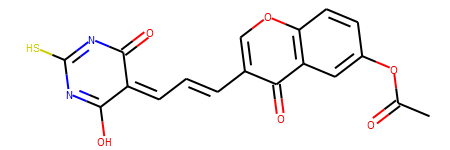

Properties for range 0-4000 cm-1 
P=11.249 A=7.717 R=5.461
P for range 513.0-2310.0 cm-1 = 11.249


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


Best normal modes in range 513.0-2310.0 cm-1, type P
--------------------------------------------------
Mode 93 at 1614.1 cm-1 / 48.39 THz
Conversion Intensity 	6.61e-25 km cm^2/(sr mol)
Raman Stokes Intensity 	8.48e-29 cm^2/sr
IR Intensity 		1.31e+03 km/mol
--------------------------------------------------
Mode 91 at 1567.9 cm-1 / 47.00 THz
Conversion Intensity 	6.04e-26 km cm^2/(sr mol)
Raman Stokes Intensity 	2.26e-29 cm^2/sr
IR Intensity 		4.80e+02 km/mol
--------------------------------------------------
Mode 73 at 1212.1 cm-1 / 36.34 THz
Conversion Intensity 	2.56e-26 km cm^2/(sr mol)
Raman Stokes Intensity 	9.57e-30 cm^2/sr
IR Intensity 		7.03e+02 km/mol
--------------------------------------------------

###################################################################
Molecule 000-773-240
###################################################################


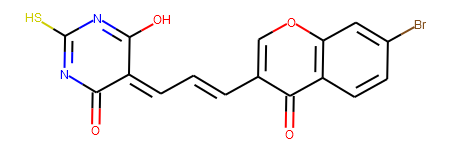

Properties for range 0-4000 cm-1 
P=10.971 A=7.479 R=5.291
P for range 513.0-2310.0 cm-1 = 10.970


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …


Best normal modes in range 513.0-2310.0 cm-1, type P
--------------------------------------------------
Mode 79 at 1605.0 cm-1 / 48.12 THz
Conversion Intensity 	4.46e-25 km cm^2/(sr mol)
Raman Stokes Intensity 	7.22e-29 cm^2/sr
IR Intensity 		1.03e+03 km/mol
--------------------------------------------------
Mode 77 at 1569.8 cm-1 / 47.06 THz
Conversion Intensity 	6.53e-26 km cm^2/(sr mol)
Raman Stokes Intensity 	2.48e-29 cm^2/sr
IR Intensity 		4.51e+02 km/mol
--------------------------------------------------
Mode 76 at 1529.4 cm-1 / 45.85 THz
Conversion Intensity 	5.06e-26 km cm^2/(sr mol)
Raman Stokes Intensity 	1.88e-29 cm^2/sr
IR Intensity 		9.11e+02 km/mol
--------------------------------------------------


In [8]:
if 'target_type' in interactive_plot.kwargs:
    conv_data=np.zeros((nummols*nummodes,7))
    cm_thz=0.0299792458 # conversion factor from cm-1 to THz

    for nm,mm in enumerate(bestmols):
        print("\n###################################################################")
        mcode=fname[mm].split("_",1)[0]

        print("Molecule {}".format(mcode.split("-",1)[1]))
        print("###################################################################")
        display(mols[nm])
        print("Properties for range {}-{} cm-1 \nP={:.3f} A={:.3f} R={:.3f}".format(xmin,xmax,P[mm],A[mm],R[mm]))
        print("{} for range {}-{} cm-1 = {:.3f}".format(target_type,tmin,tmax,target[mm]))


        wn,R_spec,IR_spec,conv_spec=broadened_spec_single(freqs[mm],  
                                                            IR_fre[mm], R_fre[mm], P_fre[mm],
                                                            tmin,tmax,res,gammaIR,gammaR,sclf)

        plot_spectra(wn,R_spec,IR_spec,conv_spec,tmin,tmax,res,mcode)

        bestmodes=np.argsort(intens_range[mm,:],axis=0)[-nummodes:]
        print("\nBest normal modes in range {}-{} cm-1, type {}".format(tmin,tmax,target_type))
        print("--------------------------------------------------")
        for mi,mode in enumerate(reversed(bestmodes)):         
                            if intens_range[mm,mode]==0:
                                conv_data[nm*nummodes+mi,:]=0
                                print("Mode with zero target intensity")
                                print("--------------------------------------------------")
                                continue
                            freqm=freqs[mm,mode]
                            thz=cm_thz*freqm
                            print("Mode {} at {:.1f} cm-1 / {:.2f} THz".format(mode,freqm,thz))
                            print("Conversion Intensity \t{:.2e} km cm^2/(sr mol)".format(prod_ints[mm,mode]))
                            print("Raman Stokes Intensity \t{:.2e} cm^2/sr".format(R_ints[mm,mode]))
                            print("IR Intensity \t\t{:.2e} km/mol".format(IR_ints[mm,mode]))
                            print("--------------------------------------------------")
                            conv_data[nm*nummodes+mi,0]=mm
                            conv_data[nm*nummodes+mi,1]=mode
                            conv_data[nm*nummodes+mi,2]=freqm
                            conv_data[nm*nummodes+mi,3]=thz
                            conv_data[nm*nummodes+mi,4]=prod_ints[mm,mode]
                            conv_data[nm*nummodes+mi,5]=R_ints[mm,mode]
                            conv_data[nm*nummodes+mi,6]=IR_ints[mm,mode]